In [41]:
import torch
torch.set_default_dtype(torch.float64)
import sys
sys.path.append("../")
import torch.nn as nn
from simulations.simulator import wiener
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc
import pickle
import matplotlib.patches as mpatches
from functions.scaler import StandardScaler
import scoringrules as sr
import nonlinear_benchmarks # used just for metrics
import pandas as pd
from model.gp_train_batch import train_gp
from model.models import DeepGP_Wiener, DeepGP_LTI_only
from dynonetloc.dynonet_train import train_dynonet

device = torch.device("cpu")#change to cuda if  gpu

## Generate data

In [32]:

# # Generate data from a linear system followed by a static nonlinearity

# In[5]:
N = 2500  # total number of data points
N_train = 1500  #
deltat = 1/100.0 # sampling rate

number_in_b = 2  # number of inputs - they are shifted cosine functions
num_states = 5
number_in_l = 1  # number of columns of the matrix L which defines the covariance of the noise as LL^T

# add measreument noise
noisestd = 0.1 #10%

# static nonlinearity
def nonlinear(x):
    return x*(x>0) 

#generate data
deterministic = False #if false it adds process noise
t, u, y, parameters = wiener(
            deltat,
            N,
            N_train,
            num_states=num_states,
            number_in_b=number_in_b,
            number_in_l=1,
            jitter=1e-8,
            nonlinear=nonlinear,
            deterministic=deterministic,
        )  # torch.exp)


#add noise
ys = y.std()
y = y + noisestd*ys* torch.randn(*y.shape)
y = y[None,:]

# prepare train and test        
time_tr = t[0:N_train, :]
time_te = t

uscaler=StandardScaler()
uscaler.fit(u[:, 0:N_train, :],dim=1)
#uscaler.transform(u[:, 0:N_train, :])
train_x_orig = torch.cat(
    [time_tr.expand(u.shape[0],*time_tr.shape), u[:, 0:N_train, :]], dim=2
)
train_x = torch.cat(
    [time_tr.expand(u.shape[0],*time_tr.shape), uscaler.transform(u[:, 0:N_train, :])], dim=2
)  # the input is the stacking of time and u [t,u]
yscaler = StandardScaler()
yscaler.fit(y[:,0:N_train],dim=1)
train_y_orig=y[:,0:N_train]
train_y = yscaler.transform(y[:,0:N_train])
train_u = uscaler.transform(u[:, :N_train, :])

# we test it on all the data
test_x_origin = torch.cat([time_te.expand(u.shape[0],*time_te.shape), u], dim=2)
test_x = torch.cat([time_te.expand(u.shape[0],*time_te.shape), uscaler.transform(u)], dim=2)
test_y_orig= y
test_y = yscaler.transform(y)


shiftp0 = 1000
shiftp = np.minimum(shiftp0,N_train)
test_x = test_x[:,N_train-shiftp:,...]
test_x_orig = test_x_origin[:,N_train-shiftp:,...]
test_y = test_y[:,N_train-shiftp:,...]
test_y_orig = test_y_orig[:,N_train-shiftp:,...]
test_u = uscaler.transform(u[:,N_train-shiftp:, ...])

print(test_y_orig.shape,test_x.shape)

torch.Size([1, 2000]) torch.Size([1, 2000, 3])


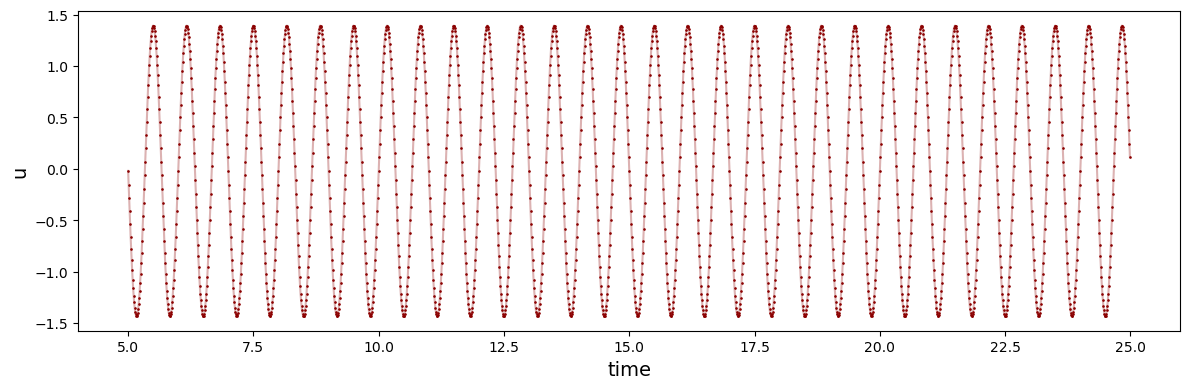

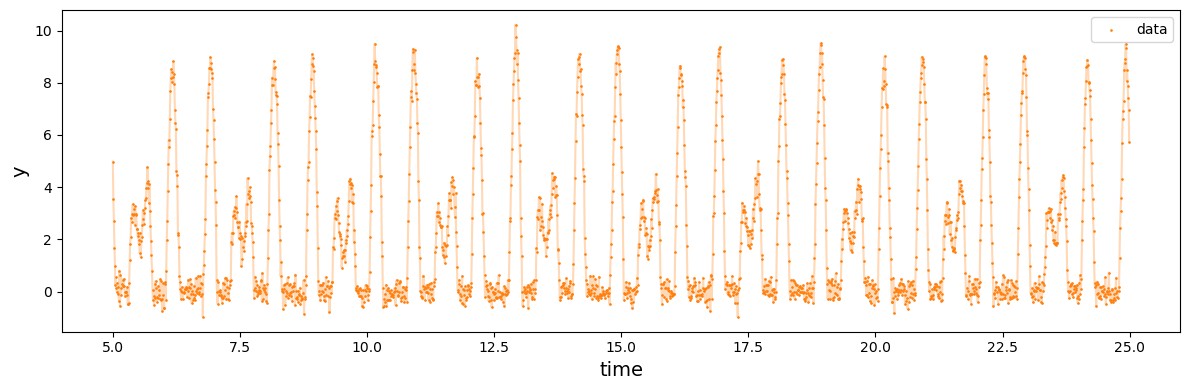

In [33]:
fig,ax=plt.subplots(figsize=(12,4))
uall=test_x[0,:,1]
tall=test_x[0,:,0]
ax.scatter(tall.flatten(),uall.flatten(),color='darkred',s=0.8,zorder=1e6,label="input")
plt.plot(tall.flatten(),uall.flatten(),color='darkred',alpha=0.3)
plt.ylabel("u",fontsize=14)
plt.xlabel("time",fontsize=14)
#plt.legend()
plt.tight_layout()

fig,ax=plt.subplots(figsize=(12,4))
ax.scatter(tall.flatten(),test_y_orig.flatten(),color='C1',s=0.8,zorder=1e6,label="data")
plt.plot(tall.flatten(),test_y_orig.flatten(),color='C1',alpha=0.3)
plt.legend()
plt.ylabel("y",fontsize=14)
plt.xlabel("time",fontsize=14)
plt.tight_layout()

In [34]:
# train dynoNet
n_input=number_in_b
n_output=1
n_a=[10]
n_b=[10]
n_hidden=[32]
pred_NN = train_dynonet(n_input,n_output,n_a,n_b,n_hidden,train_y,test_y,train_u,test_u,itertr=5000,typeD="Wiener")#
test_y_hat = yscaler.inverse_transform( torch.tensor(pred_NN).squeeze()).numpy()
test_y_hat=test_y_hat[0]



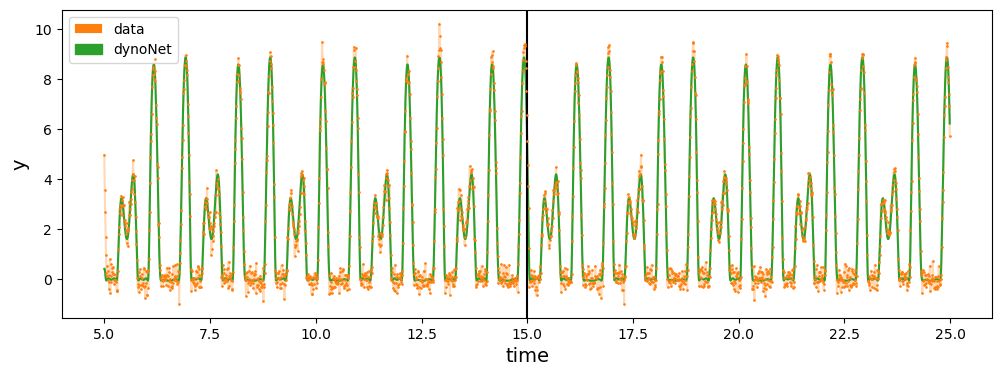

In [43]:
fig,ax=plt.subplots(figsize=(12,4))
ax.scatter(tall.flatten(),test_y_orig.flatten(),color='C1',s=0.8,zorder=1e6,label="data")
plt.plot(tall.flatten(),test_y_orig.flatten(),color='C1',alpha=0.3)
ax.plot(tall.flatten(),test_y_hat,label="dynoNet",color='C2')
ax.axvline(time_tr[-1],color='black')#end of training data
plt.ylabel("y",fontsize=14)
plt.xlabel("time",fontsize=14)
r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
b_patch = mpatches.Patch(color='C2', label='dynoNet')
plt.legend(handles=[r_patch,b_patch])

## dynoGP

In [ ]:

architecture =  'jordan' 

number_in=number_in_b
number_out=1
 
batch_size = int(np.minimum(N_train,375))

model=DeepGP_Wiener(number_in,number_out, time_tr.to(device),deltat,batch_size=batch_size,
                 num_states_dynlayer=[5],#10
                 number_in_l_dynlayer=[1],
                 num_inducing_dynlayer=[800],   #800                      
                 parametrisation_dynlayer=[architecture],
                 num_inducing_nonlin=[200],
                     initialization_type="normal"
                 ) #200

predictive_means,predictive_variances= train_gp(model.to(device),train_x.to(device),train_y.to(device),test_x.to(device),
                                                training_iter=2000,batch_size=batch_size,learning_rate=0.002)#
predictive_means = predictive_means[...,0,:]
predictive_variances = predictive_variances[...,0,:]
nsamples = predictive_means.shape[1]
for i in range(nsamples):
    predictive_means[:,i,:] = yscaler.inverse_transform(torch.tensor(predictive_means[:,i,:])).numpy()
    predictive_variances[:,i,:] = ((yscaler.std**2)*torch.tensor(predictive_variances[:,i,:])).numpy()

test_y_hat_GP = np.median(predictive_means[0],axis=0).flatten()


   

Iter 158/2000:  50%|███████▌       | 2/4 [00:00<00:00,  2.13batch/s, loss=0.473]